Same code from PINN we have been working with

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import numpy as np

# Prevents crashes when showing graphs
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
SIM_STEPS = 201

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# Pre-Determined train/test/val split
train_sims = np.load("../train_sims.npy")
train_sims = train_sims[train_sims < 750]
val_sims = np.load("../val_sims.npy")
val_sims = val_sims[val_sims < 750]
test_sims = np.load("../test_sims.npy")
test_sims = test_sims[test_sims < 750]

# Get porosity phi
def get_phi(sim,step):
    return cv2.imread(f"../Data200x200_withinfo/Image-{sim}-{step}_phi.jpg", cv2.IMREAD_GRAYSCALE)

# Get pressure
def get_pres(sim,step):
    return cv2.imread(f"../Data200x200_withinfo/Image-{sim}-{step}_P.jpg", cv2.IMREAD_GRAYSCALE)

# Get conductivity K
def get_k(sim,step):
    return cv2.imread(f"../Data200x200_withinfo/Image-{sim}-{step}_K.jpg", cv2.IMREAD_GRAYSCALE)

# Get all 3 as a 3-channel matrix
def get_all(sim,step):
    return np.array((get_k(sim,step), get_pres(sim,step), get_phi(sim,step)), dtype=np.float32)

In [ ]:
# Darcy loss function
def darcy_loss(model, inp):
    # Takes in the k,pres,phi and outputs the prediction across the image.
    inp = inp.requires_grad_(True)
    out = model(inp)
    # out is in order K,P,phi, (conductivity, pressure, porosity)

    # Impose high pressure along the entire upper line by setting the pressure channelt to 200.
    out[:, 1:2, 0, :] = 200

    # If we assume the output is in order k,pres,phi
    # pres_grad is the gradient of the pressure along the y and x directions as a tuple
    pres_grad = torch.gradient(out[:, 1:2], dim=(-2,-1))

    # get velocity by multiplying the gradient by the conductivity
    y_grad = pres_grad[0] * out[:, 0:1]
    x_grad = pres_grad[1] * out[:, 0:1]

    # compute the divergence by the second derivative of the gradients and adding them together
    yy_grad = torch.gradient(y_grad, spacing=(1,),dim=(-2,))[0]
    xx_grad = torch.gradient(x_grad, spacing=(1,),dim=(-1,))[0]
    final = yy_grad + xx_grad

    # total divergence should be 0
    loss = (final**2).mean()

    return loss, out

In [ ]:
# Building Blocks of the Unet

class TwoConv(nn.Module):
    # Basic block with 2 convolutional layers, each with a batch norm and relu
    
    def __init__(self, in_channels, out_channels, no_end_relu=False):
        super().__init__()
        
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        if no_end_relu:
            self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            )

    def forward(self, inp):
        return self.seq(inp)

# A single conv layer that will increase the height and width of the matrix by 2 each.
class SmallUp(nn.Module):

    def __init__(self, channels):
        super().__init__()

        self.conv = nn.Conv2d(channels, channels, 3, 1, 2)

    def forward(self, inp):
        return F.relu(self.conv(inp))

# A single conv layer that will decrease the height and width of the matrix by 2 each.
class SmallDown(nn.Module):

    def __init__(self, channels):
        super().__init__()

        self.conv = nn.Conv2d(channels, channels, 3, 1, 0)

    def forward(self, inp):
        return F.relu(self.conv(inp))
    
# Applies two convolutional layers, then pools
class Downsample(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = TwoConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, inp):

        return self.pool(self.conv(inp))

# Upsamples and concatenates the upsampled matrix with the "across" then performs convolution on the result
class Upsample(nn.Module):

    def __init__(self, in_channels, out_channels, tweak=None):
        super().__init__()
        # Upsamples by 2x
        self.up = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1)
        self.tweak = tweak
        self.conv_after = TwoConv(in_channels, out_channels)

    def forward(self, below, across):
        # First upsample by 2x
        upsampled = self.up(below)
        # If tweak is active, apply it first
        if not self.tweak == None:
            upsampled = self.tweak(upsampled)
        # Concatenate with the same size on the downswing of the unet
        concat = torch.concat((upsampled, across), dim=-3)
        # Convolute them together
        return self.conv_after(concat)
    
# Define the actual model used
class SmallUnet(nn.Module):
    
    def __init__(self):
        super().__init__()

        # Input is Nx3x200x200
        self.c1 = TwoConv(3, 8)
        self.d1 = Downsample(8,16) # 16x100x100
        self.d2 = Downsample(16,32) # 32x50x50
        self.su = nn.Sequential(
            SmallUp(32),
            SmallUp(32),
            SmallUp(32)
        ) # 3x56x56
        self.d3 = Downsample(32,64) # 64x28x28
        self.d4 = Downsample(64,128) # 128x14x14
        self.d5 = Downsample(128, 256) # 256x7x7

        # Now back up
        self.u1 = Upsample(256, 128) # 128x14x14
        self.u2 = Upsample(128, 64) # 64x28x28
        self.u3 = Upsample(64, 32, tweak=nn.Sequential(
            SmallDown(32),
            SmallDown(32),
            SmallDown(32)
        ))  # 32x50x50
        self.u4 = Upsample(32,16) # 16x100x100
        self.u5 = Upsample(16,8) # 8x200x200
        self.final = TwoConv(8, 3, no_end_relu=True)

    def forward(self, input):
        # Start with convolution, expand 3 channels to 8.
        # Then downsample 5 times, saving the result
        top = self.c1(input)
        x1 = self.d1(top)
        x2 = self.d2(x1)
        x3 = self.d3(self.su(x2)) # Here we upsample slightly so that we can downsample with less border artifacts
        x4 = self.d4(x3)
        x5 = self.d5(x4)
        # Now that we're at 256x7x7, we upsample from here.
        # At each layer with concatenate with the xi that is the same size as the up after upsampling.
        up = self.u1(x5, x4)
        up = self.u2(up, x3)
        up = self.u3(up, x2) # Again, a small downsample here to get back on the proper resolution
        up = self.u4(up, x1)
        up = self.u5(up, top)
        # One last convolution on the result to return to 3 channels from 8, leaving us with the proper 3x200x200
        return self.final(up)

# New Parameters 
**`return_mask`** : Used for visualizing mask. Check bottom of file for example

**`reveal_dim`** : Two lists of tuples for y, x dimension. Marks areas for sensor points to appear

**`jitter_std`** : pixel standard deviation for sensor points to move around

**`deterministic_mask`** : If true, sensor points do not jitter

**`future_delta`** : In progress, changes label from current time to current + delta


In [ ]:
class MaskedDataset(torch.utils.data.Dataset):

    def __init__(self,
                 sims,
                 unmask_size=20,
                 points = None,
                 block_size = 50,
                 reveal_strategy = "block",
                 n_points = 200,
                 radius = 2,
                 steps = None,
                 H=200,
                 W=200,
                 channels="all",
                 mixed=False,
                 types=None,
                 noise=5,
                 return_mask=False,                 # allows visualiztion of mask
                 reveal_dim=[[(0, 1)], [(0, 1)]],   # x,y range for disks to exist
                 jitter_std=0.0,                    # % each disk drifts from deterministic position
                 deterministic_mask=True,            # if True, mask is deterministic and noise is 0
                 future_delta=0
                 ):
        
        self.sims = sims
        self.points = points
        self.steps = steps
        self.size = unmask_size
        self.reveal_strategy = reveal_strategy
        self.block_size = block_size
        self.n_points = n_points
        self.radius = radius
        self.H, self.W = H, W
        self.channels = channels
        self.mixed = mixed
        self.types = types
        self.noise = noise
        self.return_mask = return_mask
        self.reveal_dim = reveal_dim
        self.jitter_std = jitter_std
        self.deterministic_mask = deterministic_mask
        self.future_delta = future_delta

    def _chan_idx(self):
        if self.channels == "all":
            return [0,1,2]
        elif self.channels == "K":
            return [0]
        elif self.channels == "P":
            return [1]
        elif self.channels == "phi":
            return [2]
        else:
            raise ValueError("channels must be 'all', 'K', 'P', or 'phi'")

    
    

    def __getitem__(self, index):
        
        # --- In Progress --- 

            # pick a valid step
        if not isinstance(self.steps, np.ndarray):
            max_start = SIM_STEPS - 1 - self.future_delta  # ensures step + delta ≤ 199
            step = np.random.randint(1, max_start + 1)  
        else:
            step = int(self.steps[index])
            max_start = SIM_STEPS - 1 - self.future_delta
            if step > max_start:
                step = max_start



        # if not type(self.steps) == np.ndarray:
        #     step = np.random.randint(1,200)
        # else:
        #     step = self.steps[index]



        # Create tensor for the target
        t_cur = torch.tensor(get_all(self.sims[index], step), dtype=torch.float32)

        # Create 0 matrix
        z = torch.zeros_like(t_cur)

        # build a boolean mask of revealed pixels, shape (H,W)
        mask = torch.zeros((self.H, self.W), dtype=torch.bool)

        chans = self._chan_idx()

        if self.reveal_strategy == "block":
            # choose top-left for the block
            if not type(self.points) == np.ndarray:
                i0 = np.random.randint(0, self.H - self.block_size + 1)
                j0 = np.random.randint(0, self.W - self.block_size + 1)
            else:
                i0, j0 = self.points[index]
                i0 = max(0, min(i0, self.H - self.block_size))
                j0 = max(0, min(j0, self.W - self.block_size))
            mask[i0:i0+self.block_size, j0:j0+self.block_size] = True

        elif self.reveal_strategy == "disks":

            # used for reveal_dim
            # map fraction [0,1] to pixel indices [0, N-1] in mask layer
            def _segments_to_indices(segments, N, pad=0):
                idxs = []
                for a, b in segments:
                    i0 = max(pad, int(round(a * (N - 1))))
                    i1 = min((N - 1) - pad, int(round(b * (N - 1))))
                    if i1 >= i0:
                        idxs.append(torch.arange(i0, i1 + 1, dtype=torch.long))
                if not idxs:
                    # fallback to full range
                    return torch.arange(pad, N - pad, dtype=torch.long)
                return torch.unique(torch.cat(idxs)).to(torch.long)

            row_fracs = self.reveal_dim[0] # e.g, [(0, 1)]
            col_fracs = self.reveal_dim[1] # e.g, [(0, 1)]
            row_allowed = _segments_to_indices(row_fracs, self.H, pad=self.radius)
            col_allowed = _segments_to_indices(col_fracs, self.W, pad=self.radius)

            # choose grid shape close to aspect ratio 
            # works with non-squares
            Hspan = (row_allowed[-1] - row_allowed[0] + 1) if len(row_allowed) > 0 else self.H
            Wspan = (col_allowed[-1] - col_allowed[0] + 1) if len(col_allowed) > 0 else self.W
            ratio = float(Wspan) / max(1.0, float(Hspan))
            ny = int(max(1, round(np.sqrt(self.n_points / max(1e-8, ratio)))))
            nx = int(max(1, round(self.n_points / ny)))
            while nx * ny < self.n_points:
                nx += 1

            # pick evenly spaced indices from rows/cols allowed
            def pick_lin_indices(allowed, k):
                if k <= 1:
                    return allowed[len(allowed)//2]
                pos = torch.linspace(0, len(allowed)-1, steps=k)
                idx = torch.round(pos).long()
                return allowed[idx]
            
            
            row_picks = pick_lin_indices(row_allowed, ny)
            col_picks = pick_lin_indices(col_allowed, nx)
            yy, xx = torch.meshgrid(row_picks, col_picks, indexing="ij")
            points = torch.stack([yy.reshape(-1), xx.reshape(-1)], dim=1) # (ny*nx, 2)
            
            # if more than n_points, subselect
            if points.shape[0] > self.n_points:
                sel_pos = torch.linspace(0, points.shape[0]-1, steps=self.n_points)
                sel_idx = torch.round(sel_pos).long()
                points = points[sel_idx]

            ii = points[:, 0]
            jj = points[:, 1]

            if not self.deterministic_mask:
                if self.jitter_std is not None and self.jitter_std > 0:
                    # convert std (like 0.01 of image size) to pixels
                    sigmaH = float(self.jitter_std) * self.H
                    sigmaW = float(self.jitter_std) * self.W
                    
                    # Add Gaussian noise in pixel units
                    ii = ii.to(torch.float32) + torch.randn_like(ii, dtype=torch.float32) * sigmaH
                    jj = jj.to(torch.float32) + torch.randn_like(jj, dtype=torch.float32) * sigmaW

                    # Round and clamp so they stay inside bounds
                    ii = ii.round().clamp(self.radius, self.H - 1 - self.radius).to(torch.long)
                    jj = jj.round().clamp(self.radius, self.W - 1 - self.radius).to(torch.long)




            yy, xx = torch.meshgrid(torch.arange(self.H), torch.arange(self.W), indexing="ij")
            for y0, x0 in zip(ii, jj):
                disk = (yy - int(y0))**2 + (xx - int(x0))**2 <= (self.radius**2)
                mask |= disk
        else:
            raise ValueError(f"Unknown reveal_strategy: {self.reveal_strategy}")
        

        obs = t_cur[chans].clone()
        # Add noise (0 - 255 scale)
        if self.noise is not None and self.noise > 0:
            sigma = float(self.noise)
            obs = obs + sigma * torch.randn_like(obs)
            obs.clamp_(0.0, 255.0)


        z[chans, :, :] = torch.where(mask, obs, torch.zeros_like(obs))








        # --- In Progress --- 

        if self.future_delta > 0:
            step_f = step + self.future_delta   
            t_label = torch.tensor(get_all(self.sims[index], step_f), dtype=torch.float32)
        else:
            t_label = t_cur.clone()



        if self.return_mask:
            return z,t_label, mask
        else:  
            return z,t_label
    
    def __len__(self):
        return self.sims.shape[0]


In [ ]:
def save_meta(name, **kwargs):
    """
    Saves meta info so you can reconstruct the exact val dataset later.
    Usage:
        save_meta(
            name,
            reveal_strategy=reveal_strategy, n_points=n_points, radius=radius,
            noise=noise, channels=channels, val_steps=val_steps, val_points=val_points,
            reveal_dim=reveal_dim, deterministic_mask_train=deterministic_mask,
            jitter_std_train=jitter_std, deterministic_mask_val=True, jitter_std_val=0.0,
            mixed=mixed, future_delta=future_delta
        )
    """
    # sanitize and cast
    arr = {}
    for k, v in kwargs.items():
        if v is None:
            continue
        if k in {"reveal_dim"}:
            arr[k] = np.array(v, dtype=object)         # keep nested structure
        elif isinstance(v, (list, tuple)) and k not in {"val_steps", "val_points"}:
            arr[k] = np.array(v)
        else:
            arr[k] = v

    np.savez(f"meta_{name}.npz", **arr)

In [ ]:
def train(
    train_loader,
    val_loader,
    model,
    optim,
    schedule=None,
    crit=nn.MSELoss(),
    epochs=250,
    name="run",
    save_model=True,
    save_curves=True,
):
    """
    Trains model with Darcy loss + supervised loss.
    Returns a dict of learning curves; optionally saves model and curves.

    Curves:
      - train_total, train_darcy
      - val_total,   val_darcy
    """
    # Histories
    train_total_hist, train_darcy_hist = [], []
    val_total_hist,   val_darcy_hist   = [], []

    for epoch in tqdm(range(epochs), desc=f"Training {name}"):
        # ---- TRAIN ----
        model.train()
        tot_loss_sum, darcy_loss_sum, n_train = 0.0, 0.0, 0

        for feat, label in train_loader:
            feat  = feat.to(device)
            label = label.to(device)

            optim.zero_grad()
            p_loss, out = darcy_loss(model, feat)
            s_loss      = crit(out, label)
            loss        = p_loss + s_loss

            loss.backward()
            optim.step()

            # accumulate
            bs = feat.size(0)
            n_train         += bs
            tot_loss_sum    += loss.item()  * bs
            darcy_loss_sum  += p_loss.item() * bs

        train_total = tot_loss_sum   / max(1, n_train)
        train_darcy = darcy_loss_sum / max(1, n_train)
        train_total_hist.append(train_total)
        train_darcy_hist.append(train_darcy)

        if schedule is not None:
            schedule.step()

        # ---- VALIDATE ----
        model.eval()
        tot_loss_sum, darcy_loss_sum, n_val = 0.0, 0.0, 0

        with torch.no_grad():
            for feat, label in val_loader:
                feat  = feat.to(device)
                label = label.to(device)

                p_loss, out = darcy_loss(model, feat)
                s_loss      = crit(out, label)
                loss        = p_loss + s_loss

                bs = feat.size(0)
                n_val         += bs
                tot_loss_sum  += loss.item()  * bs
                darcy_loss_sum+= p_loss.item() * bs

        val_total = tot_loss_sum   / max(1, n_val)
        val_darcy = darcy_loss_sum / max(1, n_val)
        val_total_hist.append(val_total)
        val_darcy_hist.append(val_darcy)

    # ---- SAVE ARTIFACTS ----
    if save_model:
        torch.save(model, f"{name}.pt")

    if save_curves:
        np.savez(
            f"curves_{name}.npz",
            train_total=np.array(train_total_hist, dtype=np.float32),
            train_darcy=np.array(train_darcy_hist, dtype=np.float32),
            val_total=np.array(val_total_hist, dtype=np.float32),
            val_darcy=np.array(val_darcy_hist, dtype=np.float32),
        )

    return {
        "train_total": train_total_hist,
        "train_darcy": train_darcy_hist,
        "val_total":   val_total_hist,
        "val_darcy":   val_darcy_hist,
    }

NEW:

Here you can add tests to run, each one takes a whole train test cycle

In [ ]:
tests = [
    # Short-term prediction (1-step ahead)
    {"name":"delta_1_short",
     "reveal_strategy":"disks", "n_points":16, "radius":5,
     "mixed":True, "noise":5,
     "deterministic_mask":False, "jitter_std":0.02,
     "future_delta":1},

    # Medium-term (5 steps ahead)
    {"name":"delta_5_medium",
     "reveal_strategy":"disks", "n_points":16, "radius":5,
     "mixed":True, "noise":5,
     "deterministic_mask":False, "jitter_std":0.02,
     "future_delta":5},

    # Long-term (10 steps ahead)
    {"name":"delta_10_long",
     "reveal_strategy":"disks", "n_points":16, "radius":5,
     "mixed":True, "noise":5,
     "deterministic_mask":False, "jitter_std":0.02,
     "future_delta":10},

    # Very long-term (20 steps ahead)
    {"name":"delta_20_verylong",
     "reveal_strategy":"disks", "n_points":16, "radius":5,
     "mixed":True, "noise":5,
     "deterministic_mask":False, "jitter_std":0.02,
     "future_delta":20},
]

Trains each configuration listed in `{tests}` one at a time.  
For every model trained, these files are saved:
- **`curves_{name}.npz`** – training and validation loss curves  
- **`disks_{name}.pt`** – trained model weights  
- **`meta_{name}.npz`** – run metadata (setup, noise)

These outputs are used for evaluation and comparison in **`plot.ipynb`**.

In [ ]:
results = {}

for config in tests:
    name                        = config.get("name")
    reveal_strategy             = config.get("reveal_strategy", "disks")
    n_points                    = config.get("n_points", 5)
    radius                      = config.get("radius", 4)
    noise                       = config.get("noise", 0)
    deterministic_mask          = config.get("deterministic_mask", False)   # allow jitter by default
    jitter_std                  = float(config.get("jitter_std", 0.02))     # 2% jitter
    reveal_dim                  = config.get("reveal_dim", [[(0,1)], [(0,1)]])
    channels                    = config.get("channels", "all")
    mixed                       = bool(config.get("mixed", True))
    future_delta                = int(config.get("future_delta", 0))


    # Pre-define steps and points to maintain a consistent validation set
    MAX_TIME = 201 - future_delta
    val_steps = np.random.randint(1,MAX_TIME,(val_sims.shape[0],))
    val_points = np.random.randint(0,149,(val_sims.shape[0],2))

    # --- TRAIN dataset/loader ---
    train_data = MaskedDataset(
        train_sims,
        reveal_strategy     =reveal_strategy,
        n_points            =n_points,
        radius              =radius,
        mixed               =mixed,                      
        noise               =noise,
        channels            =channels,
        reveal_dim          =reveal_dim,
        deterministic_mask  =deterministic_mask,
        jitter_std          =jitter_std,
        future_delta        =future_delta
    )
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)

    # --- VAL dataset/loader (deterministic) ---
    val_data = MaskedDataset(
        val_sims,
        reveal_strategy     =reveal_strategy,
        n_points            =n_points,
        radius              =radius,
        mixed               =mixed,
        noise               =noise,
        channels            =channels,
        points              =val_points,
        steps               =val_steps,
        reveal_dim          =reveal_dim,
        deterministic_mask  =True,            
        jitter_std          =0.0,                       
        future_delta        =future_delta
    )
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=8)

    # --- model/optim ---
    model = SmallUnet().to(device)
    optim = torch.optim.Adam(model.parameters())
    schedule = torch.optim.lr_scheduler.ExponentialLR(optim, 0.99)
    crit = nn.MSELoss()

    # --- train ---
    hist = train(train_loader, val_loader, model, optim, schedule, crit, epochs=250, name=name)
    results[name] = {"hist": hist, "model": model.state_dict()}

    # --- save meta so plotting notebook can reconstruct val_data ---
    save_meta(
        name,
        reveal_strategy=reveal_strategy,
        n_points=n_points,
        radius=radius,
        noise=noise,
        channels=channels,
        val_steps=val_steps,
        val_points=val_points,
        reveal_dim=reveal_dim,
        deterministic_mask_train=deterministic_mask,
        jitter_std_train=jitter_std,
        deterministic_mask_val=True,
        jitter_std_val=0.0,
        mixed=mixed,
        future_delta=future_delta,
    )

    del model
    torch.cuda.empty_cache()

  0%|          | 0/250 [00:13<?, ?it/s]


KeyboardInterrupt: 

Mask Visualizer

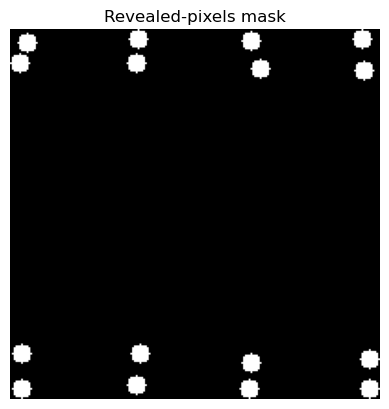

In [ ]:
# build the dataset
val_data = MaskedDataset(
    val_sims,
    reveal_strategy="disks",
    n_points=16,
    radius=5,
    noise=0,
    reveal_dim=[[(0,0.15),(0.85,1)],[(0,1)]],
    return_mask=True,
    jitter_std=0.01,
    deterministic_mask=False
)

z, t, mask = val_data[0]

import matplotlib.pyplot as plt
plt.imshow(mask.numpy(), cmap="gray")
plt.title("Revealed-pixels mask")
plt.axis("off")
plt.show()